# Classification example using TabSRALinear: Churn modelling dataset
The dataset contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer https://www.kaggle.com/code/aghelan96/churnmodelling .


## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [4]:
sys.path.append('../')
from SRAModels import TabSRALinear
from DataProcessing import load_benchmark
from utils import TrainModel,reset_seed_,Predict, load, save,LinearScaling


## Data loading, preprocessing and Split

In [5]:
data_path = '../Datasets/'
data = pd.read_csv(data_path+'Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# remove 'CustomerId','Surname' and use 'RowNumber' as index 
data.set_index('RowNumber', inplace = True)
data.drop(['CustomerId','Surname'], axis=1, inplace=True)

In [7]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
data.Exited.mean(),data.shape

(0.2037, (10000, 11))

### Some statistics 

In [9]:
data.groupby('Geography').agg({'Exited': ['mean', 'count']})

Exited      
               mean count
Geography                
France     0.161548  5014
Germany    0.324432  2509
Spain      0.166734  2477

The churn rate of customers in Germany (Geography=Germany) is twice
that of other countries

In [10]:
data.groupby('Gender').agg({'Exited': ['mean', 'count']})

Exited      
            mean count
Gender                
Female  0.250715  4543
Male    0.164559  5457

The churn rate is 16% for Gender=Male
and 25%, remaining

In [11]:
data.groupby('Tenure').agg({'Exited': ['mean', 'count']})

Exited      
            mean count
Tenure                
0       0.230024   413
1       0.224155  1035
2       0.191794  1048
3       0.211100  1009
4       0.205258   989
5       0.206522  1012
6       0.202689   967
7       0.172179  1028
8       0.192195  1025
9       0.216463   984
10      0.206122   490

The churn rate is not significantly different according to the categories of the feature tenure variable

In [12]:
data.groupby('NumOfProducts').agg({'Exited': ['mean', 'count']})

Exited      
                   mean count
NumOfProducts                
1              0.277144  5084
2              0.075817  4590
3              0.827068   266
4              1.000000    60

According to the data, customers
with important number of bank products (NumOfProducts> 2) tend to close their ac-
counts

In [13]:
data.groupby('HasCrCard').agg({'Exited': ['mean', 'count']})

Exited      
               mean count
HasCrCard                
0          0.208149  2945
1          0.201843  7055

Whether the customer has a credit card or not, the churn rate is almost the same.

In [14]:
data.groupby('IsActiveMember').agg({'Exited': ['mean', 'count']})

Exited      
                    mean count
IsActiveMember                
0               0.268509  4849
1               0.142691  5151

Active bank members have less chance of closing their account than the rest of the group.

### Preprocessing 

In [15]:
data_copy = data.copy()

In [16]:
cat_cols = ['Geography','Gender']
num_cols = ['CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary']

In [17]:
feature_names = list(data.columns)
feature_names.pop()

y = data['Exited'].values
data = data[feature_names]

scaler = StandardScaler( )
data[num_cols] = scaler.fit_transform(data[num_cols])
data = pd.get_dummies(data, columns=cat_cols)

feature_names = list(data.columns)
X = data.values
n_features = p =  X.shape[1]
n_classes = 2

### Correlation visualization (map)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [19]:
data['y'] = y

/tmp/ipykernel_66735/407588985.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


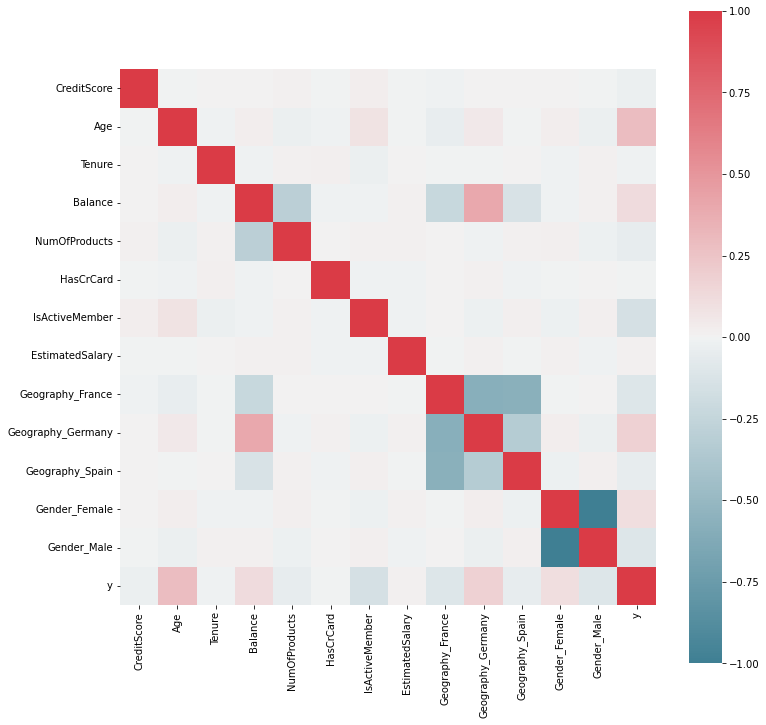

In [20]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 12))
tmp = data.astype(float) 
corr = tmp.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

The feature Age is correlate (positively) to the target variable

### Split 

In [21]:
k =5
Sf= StratifiedKFold(n_splits=k, shuffle=True, random_state= 42)
datasets = [(X[train_index], X[test_index],y[train_index], y[test_index]) for train_index,test_index in Sf.split(X, y) ]
datasets_raw = [(data_copy.iloc[train_index], data_copy.iloc[test_index]) for train_index,test_index in Sf.split(X, y) ]

In [22]:
## We use only the first fold (ie ind =0)
ind_fold =0
X_train_, X_test_, Y_train_, Y_test_ = datasets[ind_fold]
Y_train_.mean(),Y_test_.mean()

(0.203625, 0.204)

## Model: TabSRALinear 

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train_), torch.Tensor(Y_train_))
val_set = torch.utils.data.TensorDataset(torch.Tensor(X_test_), torch.Tensor(Y_test_))

In [25]:
## function to build the model
def buildTabSRA(config_opt,static_params):
    Model = TabSRALinear(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   dim_head = config_opt['dim_head'],
                   get_attention = static_params['get_attention'],
                   dropout_rate = config_opt['dropout_rate'],
                   activation = static_params['activation'],
                   bias = static_params['bias'],
                   s =  LinearScaling(scale = config_opt['dim_head']**-0.5)
                  )
    return Model

In [26]:
## The hyperparameters are already optimized (using optuna) 
config_opt = {'lr': 0.006835471440855879, 'dropout_rate': 0.2, 'dim_head': 8, 'epochs': 900, 'weight_decay': 0.00038918784304332334, 'batch_size': 512}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}


In [27]:
%%time
reset_seed_(42)
Model = buildTabSRA(config_opt,static_params)
save_model_dir= f'TabSRALinear_BankChurn_fold_{ind_fold}'
Model = TrainModel(Model, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= config_opt['epochs'],
                   batch_size = config_opt['batch_size'],
                   lr = config_opt['lr'],
                   eval_every = 5,
                   weight_decay = config_opt['weight_decay'],
                   verbose=1,
                   load_best_eval=True,
                   eval_metric='AUCROC'
                   )

epoch = 0--AUCROC perf = 0.5580629865011331 -- AUCPR perf = 0.22209333032068965
epoch = 5--AUCROC perf = 0.7795580229579269 -- AUCPR perf = 0.5073242453713772
epoch = 10--AUCROC perf = 0.7998247980096561 -- AUCPR perf = 0.5538812559286644
epoch = 15--AUCROC perf = 0.8204964774854667 -- AUCPR perf = 0.6123916013585455
epoch = 20--AUCROC perf = 0.8252290866095183 -- AUCPR perf = 0.6178796769398408
epoch = 25--AUCROC perf = 0.8273090329096463 -- AUCPR perf = 0.6282707313749909
epoch = 30--AUCROC perf = 0.8252090723223963 -- AUCPR perf = 0.6198691273938893
epoch = 35--AUCROC perf = 0.828750061582422 -- AUCPR perf = 0.6289606125887612
epoch = 40--AUCROC perf = 0.8531059094492068 -- AUCPR perf = 0.6730290188583813
epoch = 45--AUCROC perf = 0.8579739999014682 -- AUCPR perf = 0.6834021377453875
epoch = 50--AUCROC perf = 0.8592372093309686 -- AUCPR perf = 0.6867686381280992
epoch = 55--AUCROC perf = 0.8583019262981575 -- AUCPR perf = 0.6854690126585915
epoch = 60--AUCROC perf = 0.86083758252044

In [28]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
att,pred_tabsra = Predict(Model,val_set[:][0],device=device)

best_aucroc = roc_auc_score(Y_test_, pred_tabsra) 
best_aurpr = average_precision_score(Y_test_, pred_tabsra) 
print(f"--AUCROC perf = {best_aucroc} -- AUCPR perf = {best_aurpr}")

--AUCROC perf = 0.8768721056261701 -- AUCPR perf = 0.7108605936846634


**Now let's compare the achieve performance with a well tuned XGBoost model**

## Model: XGBoost 

In [29]:
from xgboost import XGBClassifier


/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [30]:
def buildXGBoost(config_opt,static_params):
    config_opt.update(static_params)
    model_xgb = XGBClassifier(**config_opt)
    return model_xgb

In [31]:
### These parameters are optimized using 30 trials with optuna (bayesian optimization)
config_opt_xgb = {
              'eta': 0.08847826679705378,
              'max_depth': 5,
              'colsample_bytree': 0.7,
              'subsample': 1.0,
              'n_estimators': 184,#1400 ,
              'min_child_weight':1

              }
static_params_xgb = {
                 'random_state':42,
                 'objective': 'binary:logistic',
                 'n_jobs': -1,
}


In [32]:
model_xgb = buildXGBoost(config_opt=config_opt_xgb,static_params=static_params_xgb)
eval_set = [(X_test_, Y_test_)]
model_xgb.fit(X_train_, Y_train_, eval_metric=['auc','aucpr'], eval_set=eval_set, verbose=1)

[0]	validation_0-auc:0.82729	validation_0-aucpr:0.65562
[1]	validation_0-auc:0.83486	validation_0-aucpr:0.66483
[2]	validation_0-auc:0.84431	validation_0-aucpr:0.66872
[3]	validation_0-auc:0.84567	validation_0-aucpr:0.67509
[4]	validation_0-auc:0.84598	validation_0-aucpr:0.67571
[5]	validation_0-auc:0.84711	validation_0-aucpr:0.67566
[6]	validation_0-auc:0.84768	validation_0-aucpr:0.67649
[7]	validation_0-auc:0.85030	validation_0-aucpr:0.67942
[8]	validation_0-auc:0.85060	validation_0-aucpr:0.68143
[9]	validation_0-auc:0.85604	validation_0-aucpr:0.68790
[10]	validation_0-auc:0.85814	validation_0-aucpr:0.68915
[11]	validation_0-auc:0.85916	validation_0-aucpr:0.69212
[12]	validation_0-auc:0.85985	validation_0-aucpr:0.69179
[13]	validation_0-auc:0.85965	validation_0-aucpr:0.69239
[14]	validation_0-auc:0.86030	validation_0-aucpr:0.69443
[15]	validation_0-auc:0.86220	validation_0-aucpr:0.69605
[16]	validation_0-auc:0.86421	validation_0-aucpr:0.69835
[17]	validation_0-auc:0.86353	validation_

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-auc:0.86446	validation_0-aucpr:0.69837
[19]	validation_0-auc:0.86481	validation_0-aucpr:0.69864
[20]	validation_0-auc:0.86441	validation_0-aucpr:0.69794
[21]	validation_0-auc:0.86454	validation_0-aucpr:0.69823
[22]	validation_0-auc:0.86426	validation_0-aucpr:0.69736
[23]	validation_0-auc:0.86430	validation_0-aucpr:0.69845
[24]	validation_0-auc:0.86417	validation_0-aucpr:0.69859
[25]	validation_0-auc:0.86444	validation_0-aucpr:0.69774
[26]	validation_0-auc:0.86492	validation_0-aucpr:0.69865
[27]	validation_0-auc:0.86511	validation_0-aucpr:0.69966
[28]	validation_0-auc:0.86525	validation_0-aucpr:0.70006
[29]	validation_0-auc:0.86525	validation_0-aucpr:0.70029
[30]	validation_0-auc:0.86588	validation_0-aucpr:0.70096
[31]	validation_0-auc:0.86587	validation_0-aucpr:0.70132
[32]	validation_0-auc:0.86587	validation_0-aucpr:0.70132
[33]	validation_0-auc:0.86647	validation_0-aucpr:0.70160
[34]	validation_0-auc:0.86614	validation_0-aucpr:0.70145
[35]	validation_0-auc:0.86625	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eta=0.08847826679705378, gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.0884782672, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=184, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [33]:
# Inference for xgboost 
pred_xgboost = model_xgb.predict_proba(X_test_)[:,1]
best_aucroc_xgb = roc_auc_score(Y_test_, pred_xgboost) 
best_aurpr_xgb = average_precision_score(Y_test_, pred_xgboost) 
print(f"--AUCROC perf = {best_aucroc_xgb} -- AUCPR perf = {best_aurpr_xgb}")

--AUCROC perf = 0.8696053798403782 -- AUCPR perf = 0.7057335754107008


## Interpretability: feature attribution on the test data

- For TabSRALinear, the feature attribution vector is $\beta\odot a\odot x$ where $\beta$ is the linear regression coefficients, $a$ the attention weights $\in [0,1]$ and $x$ the input vector.
- For XGBoost, we will use TreeSHAP https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html to get the feature attribution.

In [34]:
%%time
attributions_tabsra = pd.DataFrame(att*Model.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_tabsra.columns = feature_names
attributions_tabsra['pred_proba'] = pred_tabsra
attributions_tabsra['label'] = val_set[:][1].numpy()

CPU times: user 0 ns, sys: 25 ms, total: 25 ms
Wall time: 1.57 ms


In [35]:
%%time
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred_proba'] = pred_xgboost
attributions_xgb['label'] = val_set[:][1].numpy()

CPU times: user 2.29 s, sys: 1.61 s, total: 3.9 s
Wall time: 453 ms


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Attribution for some true positif examples

In [36]:
tp = attributions_tabsra[(attributions_tabsra.label==1) & (attributions_tabsra.pred_proba>0.8) ].sample(10, random_state=42)
tp.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,pred_proba,label
1307,-0.039814,0.779814,-0.002331,-0.005338,5.540723,0.000000,-0.855892,-0.012889,-0.000000,0.000055,-0.000000,-0.000000,-2.476384,0.922093,1.000000
216,0.028800,3.007174,-0.002877,0.910098,-0.072025,0.205218,-0.000000,-0.032434,-0.550874,0.000000,-0.000000,-0.000000,-1.293878,0.850991,1.000000
146,0.081051,3.451976,0.011771,1.464871,-0.050870,0.000000,-0.000000,0.013185,-0.444526,0.000000,-0.000000,-0.400047,-0.000000,0.975171,1.000000
1398,0.090500,1.920113,-0.014839,-0.124340,-0.151913,0.313522,-0.000000,0.022219,-0.000000,0.911231,-0.000000,-0.468466,-0.000000,0.885057,1.000000
1105,0.028829,-0.251482,-0.009103,-0.011307,5.654005,0.000711,-0.000000,0.001194,-0.000000,0.000025,-0.000000,-0.000000,-2.478887,0.922526,1.000000
1142,0.002687,1.133585,-0.008133,-0.000907,9.918386,0.000000,-0.000000,-0.005699,-0.613457,0.000000,-0.000000,-0.000000,-2.483801,0.999439,1.000000
577,0.102020,1.209727,0.005866,-0.201302,-0.086391,0.416085,-0.000000,-0.023515,-0.000000,1.273608,-0.000000,-0.286425,-0.000000,0.875758,1.000000
791,0.002018,0.923817,0.000034,-0.043810,5.571517,0.000000,-0.518414,0.030267,-0.000000,0.000000,-0.504923,-1.819937,-0.000000,0.960218,1.000000
1634,0.025841,0.627684,0.000027,-0.001194,5.596354,0.000242,-0.000000,0.011037,-0.000000,0.000005,-0.000000,-1.873906,-0.000000,0.980721,1.000000
239,0.125527,1.558286,0.008560,-0.525798,-0.050313,0.474401,-0.000000,0.016695,-0.000000,1.430462,-0.000000,-0.000000,-0.442019,0.894636,1.000000


We can notice that TabSRALinear uses mainly the NumOfProducts, Age, and Geography_Germany to assign a high churn score, this is actually in line with our data exploration!!!

Let's look at the important variables according to TreeSHAP for these same examples ( for the XGBoost model)

In [37]:
tp_attribution_xgb = attributions_xgb.iloc[tp.index]
tp_attribution_xgb.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,pred_proba,label
1307,-0.171462,1.281486,0.074495,0.669982,3.653317,0.008873,-0.225212,0.044384,0.022929,0.370669,0.005400,-0.177231,-0.073559,0.981020,1.000000
216,0.012409,2.757395,-0.079898,0.230287,0.539904,-0.016920,0.974643,-0.133096,-0.066107,-0.087737,-0.003877,-0.189382,-0.047690,0.913017,1.000000
146,-0.541625,2.558217,0.152236,0.301352,0.598177,0.050194,0.803484,-0.088477,-0.036224,-0.057954,-0.007435,0.191079,0.042733,0.918853,1.000000
1398,-0.422871,1.692600,-0.013685,-0.228918,0.406740,0.004190,0.508445,0.313230,0.062066,0.445766,0.021776,0.208079,0.076689,0.822768,1.000000
1105,0.084164,-0.328749,0.085071,0.914519,3.998839,0.004797,0.397431,-0.080903,0.034849,0.271791,0.003634,-0.131685,-0.000454,0.976210,1.000000
1142,-0.250378,1.142764,-0.005467,0.311183,4.651282,0.007757,0.258337,-0.297996,-0.095611,-0.071737,0.002617,-0.154121,-0.030175,0.980727,1.000000
577,-0.008936,0.913803,0.004298,0.288672,0.424574,0.002878,0.418902,0.017401,0.069894,0.610498,0.025574,0.136581,0.035527,0.802308,1.000000
791,-0.052303,1.399722,0.073118,0.368556,4.423463,0.052376,-0.190319,0.573228,0.017476,-0.014687,-0.016710,0.187440,0.076838,0.995318,1.000000
1634,0.082708,1.071434,-0.104487,0.191215,3.696902,-0.010149,0.281265,0.121815,0.039239,0.181134,0.001520,0.195210,0.070500,0.986339,1.000000
239,3.279532,1.013453,-0.011355,0.108845,0.603300,-0.007657,0.536348,-0.018905,0.068747,0.459340,0.020409,-0.126255,-0.056592,0.987008,1.000000


TreeSHAP also consider the NumOfProducts, Age as very important features for the XGBoost model (in n assigning a very high churn score). 
However for this datasets, TabSRALinear's  explanations are almost all succinct than the one TreeSHAP. 

We recall that we have 3 situations where we can have a very small or zero allocation with TabSRA:

(i) when the feature has very small or zero value ie $x_i \approx 0 $ (for example using one-hot-encoding)

(ii) the overall regression coefficient $\beta_i$ is close to 0

(iii) the i-th attention weight $a_i$ is very close to 0


### Attribution for some true negatif examples

In [38]:
tn = attributions_tabsra[(attributions_tabsra.label==0) & (attributions_tabsra.pred_proba<0.2) ].sample(10, random_state=42)
tn.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,pred_proba,label
561,-0.031763,-0.347871,-0.005892,-0.010959,-0.123560,0.105129,-0.000000,0.031104,-0.000000,0.277573,-0.000000,-0.000000,-1.805271,0.085621,0.000000
771,0.065190,-0.218732,-0.008026,-0.046923,0.760389,0.020202,-0.784055,-0.029680,-0.000000,0.011800,-0.000000,-0.000000,-2.365456,0.045127,0.000000
936,-0.002358,-0.619792,-0.005913,-0.354193,0.568886,0.099857,-0.000000,-0.024690,-0.457368,0.000000,-0.000000,-0.000000,-1.792202,0.045452,0.000000
691,0.009833,0.264857,0.000033,0.032885,0.217806,0.009399,-1.038895,-0.024852,-0.908643,0.000000,-0.000000,-0.000000,-2.435236,0.013001,0.000000
431,-0.066418,0.087730,-0.010377,0.064393,0.159821,0.016908,-0.979908,-0.009995,-0.865267,0.000000,-0.000000,-1.766304,-0.000000,0.021327,0.000000
1560,-0.030707,0.801011,-0.010476,0.044302,0.234067,0.016592,-0.951304,-0.009428,-0.843687,0.000000,-0.000000,-0.000000,-2.405977,0.026277,0.000000
184,0.035738,-1.293203,0.000037,-0.423688,0.776939,0.130990,-0.000000,0.034040,-0.350302,0.000000,-0.000000,-0.000000,-1.668259,0.038623,0.000000
844,0.064910,-0.881319,-0.002874,1.052592,-0.051586,0.164106,-0.000000,-0.035897,-0.000000,0.000000,-0.314055,-0.000000,-1.490585,0.124388,0.000000
810,0.020870,0.714373,0.002749,-0.059684,0.741103,0.022898,-0.790317,-0.004902,-0.000000,0.013721,-0.000000,-0.000000,-2.340254,0.105623,0.000000
630,-0.014109,0.476400,0.008304,-1.576126,0.593737,0.055997,-0.711409,0.035968,-0.000000,0.044408,-0.000000,-1.556030,-0.000000,0.043121,0.000000


The low risk costumers are usually Male (ie Gender_Male=1), are Active member (IsActiveMember=1)

In [39]:
tn_attribution_xgb = attributions_xgb.iloc[tn.index]
tn_attribution_xgb.style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,pred_proba,label
561,-0.064006,-1.273485,-0.042439,-0.583546,0.440531,-0.015763,0.449622,0.388256,0.092327,0.148451,0.002377,-0.141538,-0.061491,0.099787,0.000000
771,-0.318234,-0.041799,-0.098683,1.469974,-0.735083,-0.037333,-0.329465,-0.072636,0.018729,0.331220,0.007604,-0.082298,-0.054862,0.185163,0.000000
936,-0.012951,-0.939077,-0.065758,0.254776,-0.717012,-0.008385,0.288563,-0.021309,-0.076762,-0.087934,-0.007467,-0.120326,-0.059275,0.042623,0.000000
691,0.107001,0.546106,0.010567,-0.442257,-1.038911,-0.037852,-0.981150,-0.061969,-0.048740,-0.059403,0.001892,-0.137070,-0.062301,0.023136,0.000000
431,0.124875,0.000011,-0.009783,-0.296406,-1.147962,-0.052994,-0.207528,-0.088476,0.010935,-0.042584,0.005217,0.277524,0.128447,0.055325,0.000000
1560,-0.160821,0.994099,-0.146693,-0.372265,-1.366465,-0.040243,-0.534440,-0.073657,0.000673,-0.075536,0.000953,-0.237307,-0.078124,0.025864,0.000000
184,-0.047852,-1.101568,0.120475,0.268328,-0.739911,-0.010535,0.301260,0.043118,-0.001798,-0.046393,-0.019853,-0.129734,-0.019633,0.051029,0.000000
844,0.031346,-0.859009,0.080861,0.315656,0.636298,-0.004067,0.395641,-0.639492,0.105885,-0.050401,0.088496,-0.224706,-0.101459,0.146310,0.000000
810,0.005100,1.102102,0.039251,0.154963,-1.088407,-0.051850,-0.338480,-0.083131,0.013424,0.348516,-0.008005,-0.161493,-0.039364,0.161614,0.000000
630,-0.089625,0.623268,0.034749,-0.191068,-1.385245,-0.031989,-0.416651,-0.679752,-0.029486,0.163123,-0.003972,0.133112,0.025177,0.032696,0.000000


### Other visualizations

In [40]:
X_train_raw, X_test_raw = datasets_raw[ind_fold]


In [41]:
X_test_raw.iloc[[820,1641]]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
3941,716,Germany,Male,66,5,121411.9,1,0,0,10070.40,1
8131,704,France,Male,47,5,0.0,2,1,1,145338.61,0


In [42]:
attributions_tabsra.iloc[[820,1641]].style.background_gradient(cmap='coolwarm')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,pred_proba,label
820,-0.029548,3.725076,0.000038,-0.148476,-0.096564,0.000000,-0.000000,-0.037396,-0.000000,1.280106,-0.000000,-0.000000,-0.580435,0.974815,1.000000
1641,-0.025058,0.491623,0.000033,0.056009,0.220328,0.012268,-1.011487,0.015084,-0.872455,0.000000,-0.000000,-0.000000,-2.423395,0.018095,0.000000


We consider a high churn risk customer (RowNumber=3941) with NumOfProducts=1
(meaning that NumOfProducts is not a risk factor for this customer). The model indicates  (as below) that Age and Geography=Germany are the two most important features, which
confirms our data knowledge.

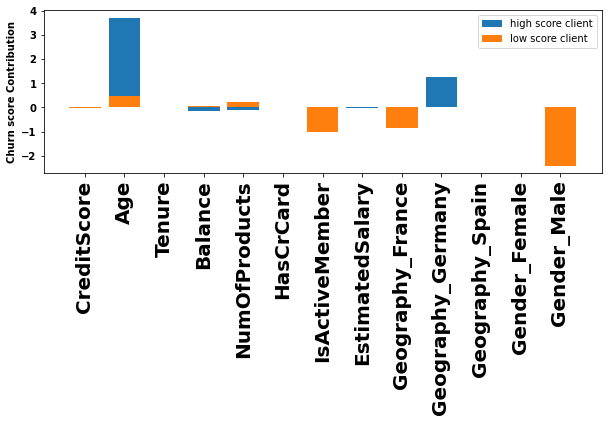

In [43]:
plt.figure(figsize=(10,3))
plt.bar( attributions_tabsra[feature_names].columns,attributions_tabsra.iloc[820][feature_names], label ='high score client')
plt.bar( attributions_tabsra[feature_names].columns,attributions_tabsra.iloc[1641][feature_names], label ='low score client')

plt.ylabel(r'Churn score Contribution',weight = 'bold')
plt.xticks(rotation=90, weight = 'bold',fontsize=20)
plt.yticks( weight = 'bold')
plt.legend()
plt.show()